# HW1 Q4
Attack on noisy prefix queries

In [8]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
from scipy.optimize import linprog
from tqdm import trange

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed = 1234
np.random.seed(seed)

### Secret initialization and release

In [177]:
# generate n bits secret x
def secret(n):
    return np.round(np.random.rand(n))  # uniform random bits

# release noisy answer a according to secret x
def release(x):
    a = np.ndarray(len(x))
    cumsum = 0
    for i in range(len(x)):
        cumsum += x[i]
        a[i] = cumsum + np.random.randint(2)
    return a

def release_2(x):
    a = np.ndarray(len(x))
    w = np.ndarray(len(x))
    cumsum = 0
    for i in range(len(x)):
        cumsum += x[i]
        a[i] = cumsum + np.random.randint(2)
        # generate w
        if np.random.randint(3)==0:
            w[i] = 1-x[i]
        else:
            w[i] = x[i]
    return a, w

## Part (a)
no prior information on the secret

### LP

In [199]:
# LP relaxation for part (a) reconstruction
def algorithm_1(a):
    n = len(a)
    
    
    # objective, n entires for \hat{s} and 1 entry for M
    s = np.zeros(n)
    s[-1] = 1
    
    # constraints
    A_eq, b_eq = [], []
    A_ub, b_ub = [], []
    
    if a[0] == 0:
        row = np.zeros(n)
        row[0] = 1
        A_eq.append(row)
        b_eq.append(0)
        
    for i in range(1, n):
        if a[i] - a[i-1] == 2:  # we know Z_i=1, Z_{i-1}=0
            row = np.zeros(n)
            row[i] = 1
            A_eq.append(row)
            b_eq.append(1)
            
            row = np.zeros(n)
            row[:i+1] = 1
            A_eq.append(row)
            b_eq.append(a[i]-1)
            
        elif a[i-1] - a[i] == 1:  # we know Z_{i-1}=1, Z_i=0
            row = np.zeros(n)
            row[i] = 1
            A_eq.append(row)
            b_eq.append(0)
            
            row = np.zeros(n)
            row[:i] = 1
            A_eq.append(row)
            b_eq.append(a[i-1]-1)
        
        else:
            
            # sum_j^i s_j <= a_i
            row = np.zeros(n)
            row[:i+1] = 1
            A_ub.append(row)
            b_ub.append(a[i])
        
            # a_i-1 <= sum_j^i s_j
            row = np.zeros(n)
            row[:i+1] = -1
            A_ub.append(row)
            b_ub.append(1-a[i])

    result = sp.optimize.linprog(s, 
                                 A_ub=A_ub, b_ub=b_ub, 
                                 A_eq=A_eq, b_eq=b_eq,
                                 bounds=(0, 1), method='highs',
                                 options={'primal_feasibility_tolerance': 1e-3,
                                          'dual_feasibility_tolerance': 1e-3,
                                          'ipm_optimality_tolerance': 1e-3})
    
    x = np.round(result.x[:n])
    
    return x, result

In [102]:
def part_a(n, k=20):
    accs = []
    for _ in trange(k):
        # generate secret, release query answers
        x = secret(n)
        a = release(x)

        # solve
        s, _ = algorithm_1(a)

        # evaluate
        acc = 1 - np.linalg.norm(x-s, ord=1) / n
        accs.append(acc)
    
    print(f'For n={n}, accuracy mean = {np.mean(accs)*100:.2f}%, std = {np.std(accs)}')
    return accs

In [103]:
ns = [100, 500, 1000, 5000]

In [104]:
accs = []
for n in ns:
    accs.append(part_a(n, k=20))

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

For n=100, accuracy mean = 75.95%, std = 0.05920092904676412


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

For n=500, accuracy mean = 75.52%, std = 0.016557777628655377


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

For n=1000, accuracy mean = 75.85%, std = 0.016536248062967624


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [06:51<00:00, 20.57s/it]

For n=5000, accuracy mean = 75.85%, std = 0.005978118433085779


In [109]:
from matplotlib import pyplot as plt

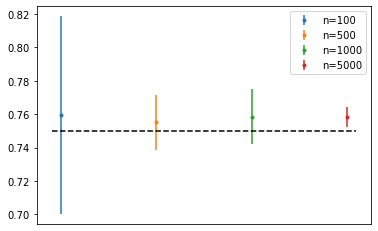

In [126]:
for i in range(4):
    plt.errorbar(x=i, y=np.mean(accs[i]), yerr=np.std(accs[i]), fmt='.', label=f'n={ns[i]}', )
plt.legend()
plt.hlines(0.75, xmin=-0.1, xmax=3.1, linestyles='dashed', colors='black')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

## Part (b)
prior $\mathbf{w}$

In [189]:
# LP relaxation for part (b) reconstruction
def algorithm_2(a, w):
    n = len(a)
    
    
    # objective, as close to w as possible
    s = np.ones(n)
    s[w==1] = -1
    
    # constraints
    A_eq, b_eq = [], []
    A_ub, b_ub = [], []
    
    if a[0] == 0:
        row = np.zeros(n)
        row[0] = 1
        A_eq.append(row)
        b_eq.append(0)
        
    for i in range(1, n):
        if a[i] - a[i-1] == 2:  # we know Z_i=1, Z_{i-1}=0
            row = np.zeros(n)
            row[i] = 1
            A_eq.append(row)
            b_eq.append(1)
            
            row = np.zeros(n)
            row[:i+1] = 1
            A_eq.append(row)
            b_eq.append(a[i]-1)
            
        elif a[i-1] - a[i] == 1:  # we know Z_{i-1}=1, Z_i=0
            row = np.zeros(n)
            row[i] = 1
            A_eq.append(row)
            b_eq.append(0)
            
            row = np.zeros(n)
            row[:i] = 1
            A_eq.append(row)
            b_eq.append(a[i-1]-1)
        
        else:
            
            # sum_j^i s_j <= a_i
            row = np.zeros(n)
            row[:i+1] = 1
            A_ub.append(row)
            b_ub.append(a[i])
        
            # a_i-1 <= sum_j^i s_j
            row = np.zeros(n)
            row[:i+1] = -1
            A_ub.append(row)
            b_ub.append(1-a[i])

    result = sp.optimize.linprog(s, 
                                 A_ub=A_ub, b_ub=b_ub, 
                                 A_eq=A_eq, b_eq=b_eq,
                                 bounds=(0, 1), method='highs',
                                 options={'primal_feasibility_tolerance': 1e-3,
                                          'dual_feasibility_tolerance': 1e-3,
                                          'ipm_optimality_tolerance': 1e-3})
    
    x = np.round(result.x[:n])
    
    return x, result

In [190]:
def part_b(n, k=20):
    accs = []
    for _ in trange(k):
        # generate secret, release query answers
        x = secret(n)
        a, w = release_2(x)

        # solve
        s, _ = algorithm_2(a, w)
    
        # evaluate
        acc = 1 - np.linalg.norm(x-s, ord=1) / n
        accs.append(acc)
    
    print(f'For n={n}, accuracy mean = {np.mean(accs)*100:.2f}%, std = {np.std(accs)}')
    return accs

In [202]:
accs_2 = []
for n in ns:
    accs_2.append(part_b(n, k=20))

 10%|████████▎                                                                          | 2/20 [00:00<00:01, 13.65it/s]

For n=100, accuracy mean = 82.70%, std = 0.050209560842532766


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

For n=500, accuracy mean = 82.61%, std = 0.015355455056754232


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

For n=1000, accuracy mean = 81.78%, std = 0.016624078921853074


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:01<00:00, 12.10s/it]

For n=5000, accuracy mean = 82.20%, std = 0.005659284407060667


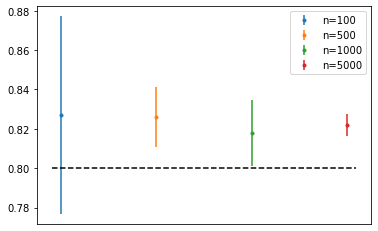

In [203]:
for i in range(4):
    plt.errorbar(x=i, y=np.mean(accs_2[i]), yerr=np.std(accs_2[i]), fmt='.', label=f'n={ns[i]}', )
plt.legend()
plt.hlines(0.8, xmin=-0.1, xmax=3.1, linestyles='dashed', colors='black')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off